In [1]:
%matplotlib inline

In [2]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd

In [3]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [5]:
# Load data
current_time = "2024-11-27T10:30Z"
n_qubits = 10
backend_qpu_name = "ibm_marrakesh"
graph_type = "line"
path = f"./data/{current_time}_{n_qubits}_{backend_qpu_name}_{graph_type}"

data_exact_df = pd.read_json(f"{path}/data_exact_df.json")
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

for key, value in params.items():
    print(f"{key}: {value}")

n_samples: 114
n_qubits: 10
backend_qpu_name: ibm_marrakesh
beta: 1
C: 100
n_features: 5
times: [0.0, 0.031415926535897934, 0.06283185307179587, 0.09424777960769379, 0.12566370614359174]
Js: [list([0.5479120971119267, -0.12224312049589536, 0.7171958398227649, 0.3947360581187278, -0.8116453042247009, 0.9512447032735118, 0.5222794039807059, 0.5721286105539076, -0.7437727346489083])
 list([-0.09922812420886573, -0.25840395153483753, 0.8535299776972036, 0.2877302401613291, 0.64552322654166, -0.11317160234533774, -0.5455225564304462, 0.1091695740316696, -0.8723654877916494])
 list([0.6552623439851641, 0.2633287982441297, 0.5161754801707477, -0.2909480637402633, 0.9413960487898065, 0.7862422426443954, 0.5567669941475237, -0.6107225842960649, -0.06655799254593164])
 list([-0.7401569893290567, -0.04859014754813251, -0.5461813018982318, 0.3396279893650207, -0.12569616225533853, 0.6653563921156749, 0.40053020400449824, -0.37526671723591787, 0.6645196027904021])
 list([0.6095287149936037, -0.2250

## Analyze data

In [ ]:
# For debugging
# data_mit_df = data_exact_df

In [6]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

In [7]:
print("Exact")
display(data_exact_df)

print("Simulator (noise free)")
display(data_sim_df)

print("Simulator (noisy)")
display(data_sim_noisy_df)

print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.992134,-0.114340,0.968693,-0.226507,0.930143,-0.334372,0.877249,-0.435894,0.434211
1,1,1,0.998365,0.040284,0.993473,0.080286,0.985362,0.119726,0.974093,0.158329,7.663109
2,2,1,0.997880,-0.027241,0.991535,-0.054284,0.981008,-0.080935,0.966374,-0.107002,2.279938
3,3,1,0.999852,-0.015253,0.999410,-0.030504,0.998673,-0.045749,0.997643,-0.060988,0.677188
4,4,1,0.998910,-0.011441,0.995646,-0.022780,0.990226,-0.033916,0.982678,-0.044749,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,1,0.998193,-0.059578,0.992781,-0.118935,0.983782,-0.177850,0.971232,-0.236103,0.155896
110,110,1,0.998730,-0.018145,0.994938,-0.036035,0.988670,-0.053417,0.980008,-0.070047,1.090458
111,111,1,0.996866,-0.069725,0.987491,-0.138897,0.971954,-0.206969,0.950385,-0.273403,0.395207
112,112,1,0.999786,-0.016421,0.999144,-0.032844,0.998075,-0.049268,0.996584,-0.065694,0.847017


Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.990032,-0.126762,0.963714,-0.231758,0.929409,-0.327034,0.874717,-0.434729,0.434211
1,1,1,0.997078,0.031999,0.989287,0.064002,0.985441,0.130185,0.971814,0.146574,7.663109
2,2,1,0.998400,-0.005142,0.981632,-0.100997,0.983999,-0.064992,0.951564,-0.136156,2.279938
3,3,1,0.999765,-0.035675,0.999863,-0.016664,0.999369,-0.039639,0.997643,-0.061603,0.677188
4,4,1,1.000386,0.005501,0.999624,-0.018432,0.990937,-0.043433,0.988878,-0.060576,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,1,0.994574,-0.114101,0.990933,-0.134360,0.986303,-0.168250,0.975857,-0.222983,0.155896
110,110,1,0.998786,-0.011249,0.997272,-0.025571,0.989379,-0.037711,0.967921,-0.072687,1.090458
111,111,1,0.989766,-0.090739,0.988061,-0.125838,0.968285,-0.232866,0.953657,-0.246545,0.395207
112,112,1,1.000131,0.032318,0.998890,-0.021292,0.995749,-0.035810,0.996918,-0.081625,0.847017


Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.853516,0.602416,-0.036473,0.609162,-0.155817,0.602800,-0.195209,0.577858,-0.249422,0.434211
1,1,0.836914,0.615245,0.048688,0.672880,0.061216,0.613356,0.108955,0.614364,0.116627,7.663109
2,2,0.834961,0.651918,0.012134,0.641798,-0.031753,0.606416,-0.048699,0.630505,0.001273,2.279938
3,3,0.848633,0.643372,-0.027194,0.648267,-0.016374,0.634137,-0.035486,0.645113,-0.056112,0.677188
4,4,0.869141,0.625784,0.016281,0.624922,-0.006616,0.637011,-0.028414,0.612718,0.009461,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,0.860352,0.620186,-0.063387,0.623236,-0.069722,0.634740,-0.113144,0.642983,-0.155340,0.155896
110,110,0.845703,0.639383,0.018441,0.626269,-0.003950,0.637061,-0.055520,0.602924,-0.061885,1.090458
111,111,0.849609,0.631973,-0.036138,0.625608,-0.101314,0.609689,-0.137028,0.624417,-0.180938,0.395207
112,112,0.858398,0.627925,-0.002395,0.621948,-0.018417,0.628172,-0.067739,0.645768,-0.051850,0.847017


no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.991547,0.725689,-0.166538,0.659061,-0.314613,0.610325,-0.398027,0.551755,-0.447488,0.434211
1,1,0.986223,0.729158,-0.075785,0.710250,-0.031053,0.694914,-0.082685,0.714554,-0.045493,7.663109
2,2,0.977645,0.629518,-0.339964,0.583426,-0.388228,0.603088,-0.349185,0.632646,-0.304993,2.279938
3,3,0.993367,0.733067,-0.107472,0.728334,-0.115812,0.700070,-0.203891,0.735103,-0.045299,0.677188
4,4,0.973383,0.725254,-0.135688,0.720682,-0.155427,0.701957,-0.116788,0.706733,-0.139004,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,0.927811,0.585124,-0.301485,0.556675,-0.325996,0.585447,-0.277012,0.587338,-0.345372,0.155896
110,110,0.913003,0.649186,-0.216388,0.623086,-0.252352,0.631836,-0.233393,0.631503,-0.209495,1.090458
111,111,0.918552,0.623706,-0.216955,0.628941,-0.217876,0.631986,-0.233180,0.564081,-0.339005,0.395207
112,112,0.926494,0.698890,-0.011408,0.679650,-0.105273,0.697897,-0.102691,0.656228,-0.241237,0.847017


mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.827148,0.604249,-0.138114,0.549272,-0.262105,0.508757,-0.331685,0.459517,-0.372491,0.434211
1,1,0.822998,0.607652,-0.063371,0.591785,-0.025905,0.579054,-0.069488,0.595424,-0.038141,7.663109
2,2,0.815186,0.524594,-0.283644,0.486223,-0.323801,0.502630,-0.291434,0.527000,-0.254416,2.279938
3,3,0.828125,0.611419,-0.089461,0.607291,-0.096347,0.584034,-0.170155,0.612915,-0.038067,0.677188
4,4,0.811279,0.604749,-0.112921,0.600432,-0.129156,0.585389,-0.097473,0.588790,-0.115266,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,0.778564,0.489479,-0.252525,0.465858,-0.272830,0.490393,-0.231344,0.490728,-0.289312,0.155896
110,110,0.769775,0.543047,-0.181196,0.521532,-0.210281,0.528858,-0.195274,0.528044,-0.175014,1.090458
111,111,0.767822,0.521974,-0.181573,0.525918,-0.182180,0.528273,-0.194576,0.472149,-0.283683,0.395207
112,112,0.778320,0.584439,-0.010042,0.568435,-0.088323,0.583776,-0.085543,0.548263,-0.201259,0.847017


## Exact

In [40]:
train_size = 0.8
session_id = 42

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(114, 11)"
4,Transformed data shape,"(114, 10)"
5,Transformed train set shape,"(91, 10)"
6,Transformed test set shape,"(23, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.2264,3.7483,1.7268,0.9110,0.3375,1.5751,0.0090
br,Bayesian Ridge,1.6563,10.0571,2.5646,0.7918,0.3933,2.0047,0.0130
rf,Random Forest Regressor,1.7597,17.0587,3.3727,0.6382,0.3126,0.4240,0.0460
huber,Huber Regressor,1.6541,17.2920,3.2034,0.7346,0.2946,0.7260,0.0120
et,Extra Trees Regressor,1.8781,18.7038,3.6731,0.5675,0.3204,0.4554,0.0430
gbr,Gradient Boosting Regressor,1.9298,19.5996,3.7456,0.5402,0.3688,0.7046,0.0160
knn,K Neighbors Regressor,2.1850,20.5170,3.9856,0.4637,0.3855,0.5548,0.0150
lightgbm,Light Gradient Boosting Machine,2.6951,21.0045,4.1564,0.4536,0.5676,2.1400,0.5430
ridge,Ridge Regression,3.1579,26.2807,4.4698,0.4380,0.6899,3.4166,0.0110
omp,Orthogonal Matching Pursuit,3.3835,27.0097,4.6385,0.3504,0.7476,4.6254,0.0100


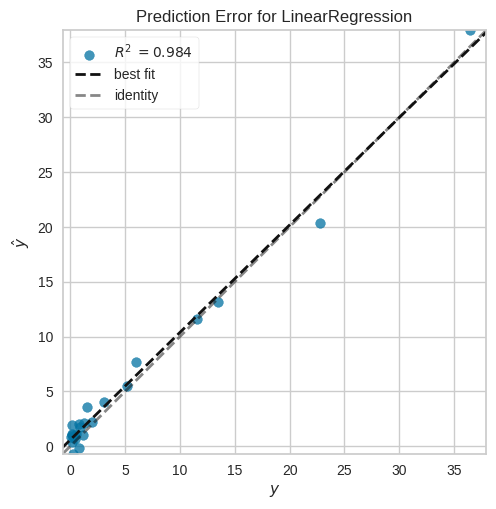

In [60]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_exact = s_exact.compare_models(turbo=True, sort="MSE")

s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(114, 11)"
4,Transformed data shape,"(114, 10)"
5,Transformed train set shape,"(91, 10)"
6,Transformed test set shape,"(23, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.0459,18.3047,3.7470,0.4665,0.3784,0.5702,0.0530
ada,AdaBoost Regressor,2.3358,19.0227,3.8685,0.4776,0.4773,1.2781,0.0170
lightgbm,Light Gradient Boosting Machine,2.6141,19.5754,3.8889,0.4576,0.5480,2.1153,0.4160
huber,Huber Regressor,2.1696,20.0969,3.6579,0.6446,0.4526,1.8839,0.0120
br,Bayesian Ridge,2.6522,20.2573,3.9402,0.5414,0.5324,2.3585,0.0100
et,Extra Trees Regressor,2.1465,20.3040,3.8719,0.3301,0.3908,0.7955,0.0370
lr,Linear Regression,2.8064,20.7730,3.9862,0.4816,0.5818,3.1325,0.0110
lar,Least Angle Regression,2.8499,21.6343,4.0488,0.4646,0.5888,3.1386,0.0100
knn,K Neighbors Regressor,2.4697,24.2291,4.4179,0.3740,0.4528,0.6911,0.0150
gbr,Gradient Boosting Regressor,2.4163,24.7400,4.3843,0.2700,0.4451,0.9096,0.0190


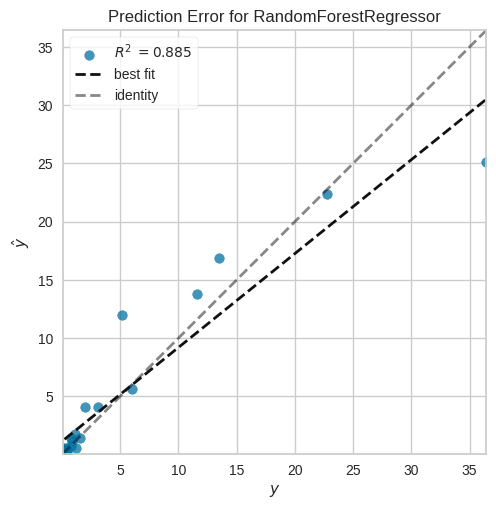

In [61]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim = s_sim.compare_models(turbo=True, sort="MSE")

s_sim.plot_model(best_sim, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:20:32
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.0792,80.1694,8.9537,0.5556,0.5695,1.1318
1,1.7405,6.5680,2.5628,0.7448,0.2402,0.3281
2,2.2389,16.4235,4.0526,0.3406,0.5539,1.5420
3,1.5805,8.3352,2.8871,0.8890,0.1624,0.2381
4,1.7484,7.5851,2.7541,0.3952,0.3708,0.8219
5,1.6149,7.3172,2.7050,0.8629,0.3181,0.6797
6,3.2818,36.3382,6.0281,-0.2893,0.6935,0.9158
7,3.2798,36.2832,6.0236,-1.8927,0.4681,1.3549
8,0.7716,1.0684,1.0336,0.9629,0.2443,0.3053


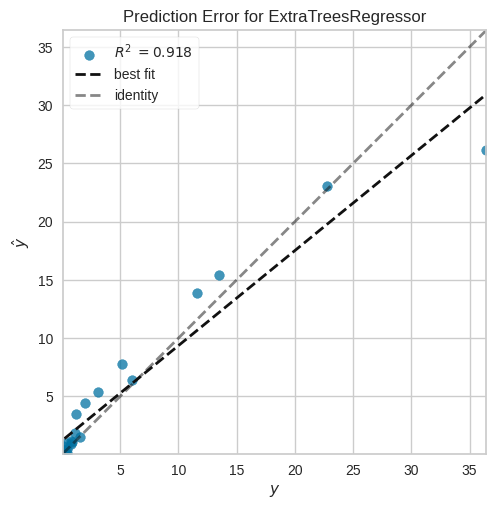

In [62]:
manual_model_sim = s_sim.create_model("et")
s_sim.plot_model(manual_model_sim, plot="error")

## Trotter (Simulation, Noisy)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(114, 11)"
4,Transformed data shape,"(114, 10)"
5,Transformed train set shape,"(91, 10)"
6,Transformed test set shape,"(23, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.1970,16.8427,3.6862,0.5498,0.4550,0.9763,0.0380
gbr,Gradient Boosting Regressor,2.3163,18.4552,4.0082,0.2819,0.4847,1.0956,0.0160
ada,AdaBoost Regressor,2.5348,19.4048,4.1605,0.3646,0.5384,1.8552,0.0170
rf,Random Forest Regressor,2.3155,19.6074,4.1107,0.3701,0.4740,1.2034,0.0510
knn,K Neighbors Regressor,2.3200,21.0153,4.0515,0.4487,0.4463,0.7404,0.0150
br,Bayesian Ridge,2.9805,21.6714,4.1357,0.4741,0.6324,2.8653,0.0090
lar,Least Angle Regression,3.1650,22.0284,4.2832,0.3853,0.6815,3.3758,0.0110
lr,Linear Regression,3.1650,22.0285,4.2832,0.3853,0.6815,3.3758,0.0110
lightgbm,Light Gradient Boosting Machine,2.8811,22.2259,4.2198,0.2525,0.6506,2.4213,0.4740
huber,Huber Regressor,2.6422,22.8377,4.0822,0.5494,0.5599,2.3969,0.0110


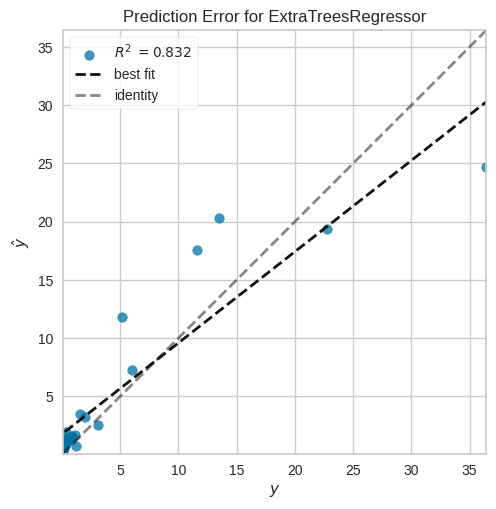

In [63]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort="MSE")
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(114, 11)"
4,Transformed data shape,"(114, 10)"
5,Transformed train set shape,"(91, 10)"
6,Transformed test set shape,"(23, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.7343,20.1696,4.0399,0.4710,0.6171,1.6446,0.0510
et,Extra Trees Regressor,2.7331,20.8072,4.1045,0.4930,0.5911,1.6175,0.0410
ada,AdaBoost Regressor,2.9337,21.0128,4.0821,0.4867,0.7165,3.2938,0.0170
gbr,Gradient Boosting Regressor,2.6816,21.0204,4.0857,0.4687,0.6010,1.6381,0.0160
dt,Decision Tree Regressor,2.4786,22.0579,3.8888,0.5272,0.5857,1.2224,0.0120
knn,K Neighbors Regressor,2.9162,23.8757,4.4765,0.3727,0.6102,1.4084,0.0170
lr,Linear Regression,3.4914,24.7934,4.5421,0.3234,0.7138,3.4002,0.0130
br,Bayesian Ridge,3.4326,24.8374,4.5609,0.3546,0.7576,4.0731,0.0090
huber,Huber Regressor,3.0237,24.9238,4.3915,0.4622,0.6097,2.1114,0.0110
lar,Least Angle Regression,3.5178,25.5830,4.5802,0.3190,0.7228,3.5069,0.0090


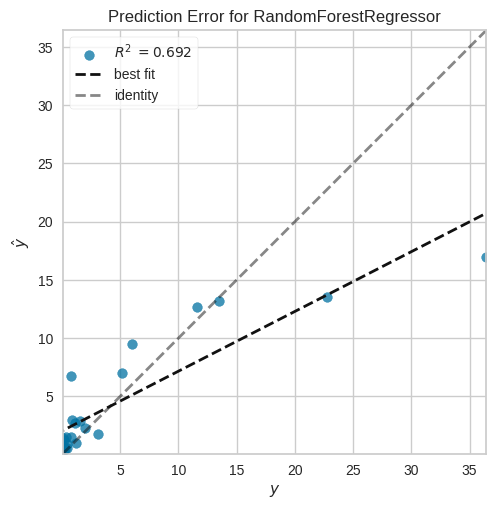

In [64]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_nmit = s_nmit.compare_models(turbo=True, sort="MSE")
s_nmit.plot_model(best_nmit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1355,89.6337,9.4675,0.5032,0.6585,2.4898
1,3.6367,18.7663,4.3320,0.2709,0.6907,1.1211
2,2.2471,11.8607,3.4439,0.5238,0.6751,2.2968
3,2.6967,14.0575,3.7493,0.8128,0.6223,1.8544
4,1.9469,7.5035,2.7393,0.4017,0.6146,1.4155
5,3.4531,23.6712,4.8653,0.5563,0.5754,1.3976
6,2.4070,26.8490,5.1816,0.0474,0.7894,0.7362
7,2.7350,12.3870,3.5195,0.0124,0.5767,1.2705
8,3.5610,30.1093,5.4872,-0.0460,0.5854,0.7630


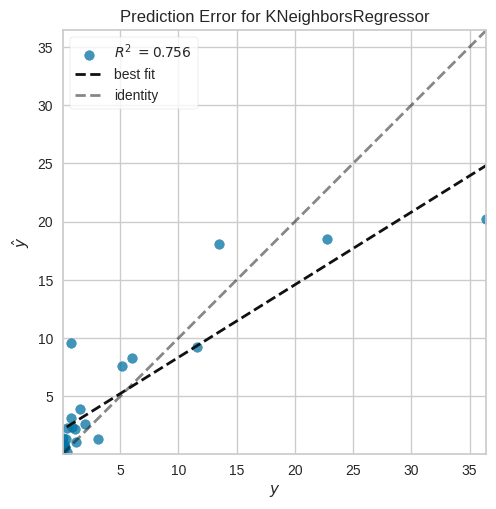

In [65]:
manual_model_nmit = s_nmit.create_model("knn")
s_nmit.plot_model(manual_model_nmit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:22:00
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.2462,89.0341,9.4358,0.5065,0.6784,2.5823
1,4.0405,25.8749,5.0867,-0.0053,0.7813,1.3733
2,2.1891,12.6788,3.5607,0.4909,0.6038,1.9021
3,2.0706,8.2579,2.8737,0.8900,0.4316,1.2630
4,2.3869,9.3344,3.0552,0.2557,0.6900,2.1801
5,2.7375,14.3303,3.7855,0.7314,0.6181,2.2452
6,2.3423,24.1462,4.9139,0.1433,0.6630,0.7226
7,2.3330,9.1436,3.0238,0.2710,0.4777,0.9528
8,3.1059,16.4157,4.0516,0.4297,0.6886,1.2701


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


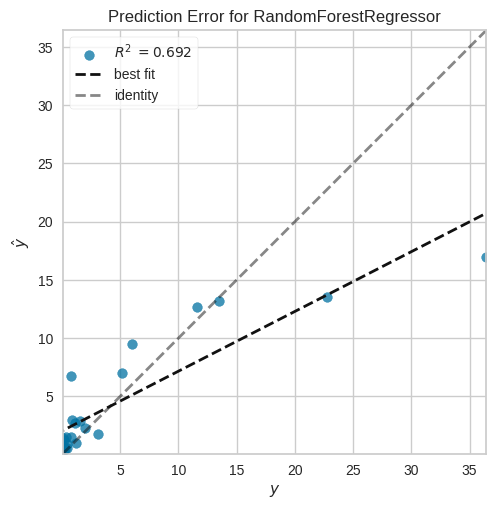

In [66]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [67]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_mit = s_mit.compare_models(turbo=True, sort="MSE")

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(114, 11)"
4,Transformed data shape,"(114, 10)"
5,Transformed train set shape,"(91, 10)"
6,Transformed test set shape,"(23, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.7281,20.2617,4.0557,0.4648,0.6103,1.6000,0.0490
et,Extra Trees Regressor,2.7062,20.3670,4.0885,0.4907,0.5902,1.5350,0.0380
gbr,Gradient Boosting Regressor,2.6017,20.7302,4.0273,0.4868,0.5697,1.4500,0.0160
dt,Decision Tree Regressor,2.5176,21.8389,3.8562,0.5335,0.5950,1.2547,0.0100
ada,AdaBoost Regressor,3.0387,22.1143,4.1723,0.4576,0.7468,3.5205,0.0170
knn,K Neighbors Regressor,2.9043,23.6793,4.4583,0.3795,0.6086,1.4067,0.0140
lightgbm,Light Gradient Boosting Machine,3.1360,24.3249,4.4208,0.3179,0.6826,1.9599,0.3280
huber,Huber Regressor,2.9918,24.6632,4.3560,0.4728,0.6047,2.0592,0.0110
lr,Linear Regression,3.4848,24.7776,4.5377,0.3230,0.7128,3.3790,0.0110
br,Bayesian Ridge,3.4312,24.8054,4.5590,0.3549,0.7571,4.0588,0.0090


In [68]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.3655,22.9580,4.7915,0.6945,0.5279,2.1940


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value,prediction_label
80,0.777344,0.584696,-0.102709,0.575105,-0.086199,0.585164,0.015193,0.565461,0.058072,13.492424,13.094969
4,0.811279,0.604749,-0.112921,0.600432,-0.129156,0.585389,-0.097473,0.588790,-0.115266,1.549202,2.830358
40,0.817383,0.582893,-0.146379,0.590319,-0.162060,0.554009,-0.235575,0.509112,-0.280330,0.477753,0.768850
69,0.830811,0.604858,-0.062951,0.592773,-0.133898,0.615718,-0.129865,0.587473,-0.165192,1.109823,2.735419
10,0.821533,0.519905,-0.335371,0.481941,-0.365898,0.557057,-0.179930,0.549688,-0.195709,1.220764,1.159793
45,0.817383,0.562939,-0.134044,0.575685,-0.092586,0.538546,-0.166135,0.568051,-0.112998,1.972227,2.069994
70,0.817139,0.618998,-0.090735,0.611490,-0.014599,0.605042,0.037088,0.607140,0.058036,36.433311,17.384982
66,0.820801,0.597345,-0.108572,0.552283,-0.252518,0.576491,-0.147041,0.572508,-0.214589,0.126650,1.320612
47,0.826172,0.613501,-0.106096,0.597990,-0.064585,0.607124,-0.077800,0.609231,-0.067195,6.009541,9.646226
11,0.824219,0.567769,-0.198198,0.591130,-0.172782,0.583305,-0.195738,0.578461,-0.171855,0.813484,1.744336


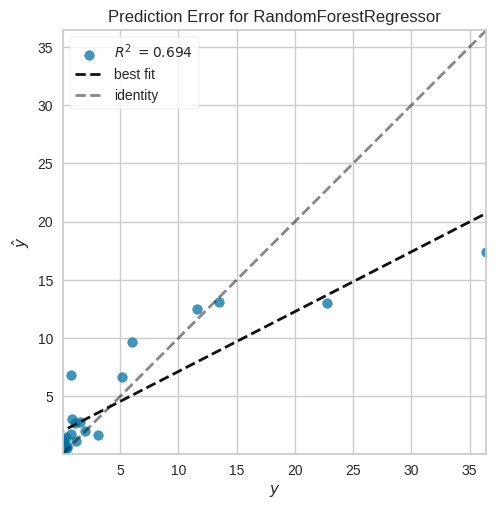

In [69]:
s_mit.plot_model(best_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.4427,89.2934,9.4495,0.5051,0.7389,3.0763
1,4.1385,26.8029,5.1771,-0.0413,0.7905,1.3890
2,2.2178,13.0406,3.6112,0.4764,0.6037,1.9029
3,2.0238,8.3970,2.8978,0.8882,0.4189,1.2093
4,2.4721,9.9490,3.1542,0.2067,0.7017,2.2582
5,2.6927,13.7784,3.7119,0.7418,0.6023,2.1326
6,2.3342,23.5463,4.8524,0.1646,0.6455,0.7400
7,2.4069,9.6420,3.1051,0.2313,0.4951,0.9763
8,2.9914,15.5158,3.9390,0.4610,0.6730,1.1922


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


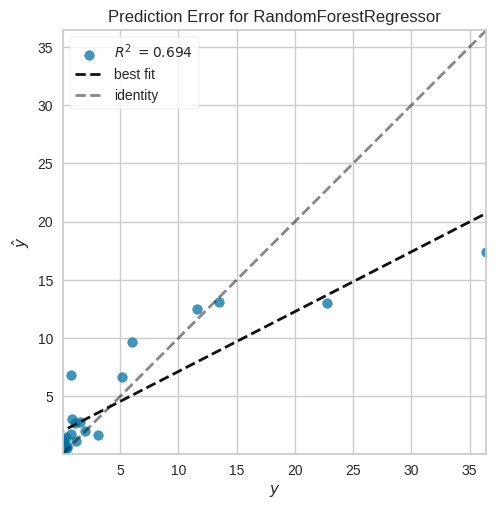

In [70]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.8584,80.4106,8.9672,0.5543,0.6523,2.2852
1,3.6357,21.7991,4.6690,0.1531,0.6703,1.1703
2,2.3092,11.2911,3.3602,0.5466,0.6583,2.4222
3,2.6589,15.0262,3.8764,0.7999,0.6142,1.8702
4,2.4550,9.1959,3.0325,0.2667,0.6902,2.0288
5,2.8237,16.0405,4.0051,0.6994,0.5872,1.8872
6,2.5251,24.8882,4.9888,0.1170,0.6662,0.6833
7,1.7109,5.0365,2.2442,0.5985,0.4238,0.9152
8,2.8666,17.5834,4.1933,0.3892,0.5409,0.8551


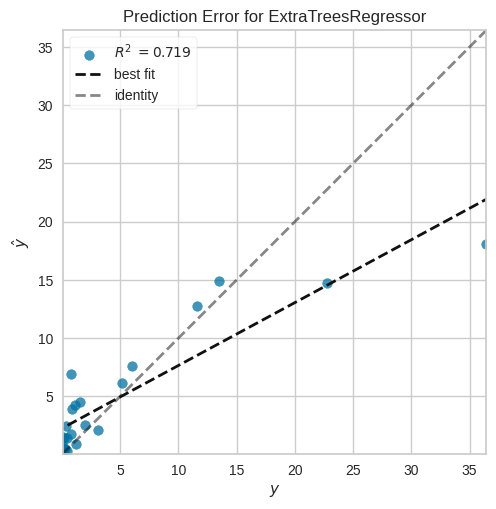

In [71]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:22:30
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.3616,91.7542,9.5788,0.4914,0.7000,2.9708
1,3.3666,18.0470,4.2482,0.2988,0.6649,1.3113
2,2.2225,12.0982,3.4782,0.5142,0.6245,2.5271
3,2.4685,11.6040,3.4065,0.8455,0.4885,1.4433
4,2.2343,8.1991,2.8634,0.3462,0.6709,2.3602
5,2.9754,12.9838,3.6033,0.7566,0.6096,2.1524
6,2.3213,22.5331,4.7469,0.2005,0.6253,0.9675
7,2.2043,7.7505,2.7840,0.3821,0.4990,1.1242
8,2.5126,10.1704,3.1891,0.6467,0.5245,0.8676


Fitting 10 folds for each of 10 candidates, totalling 100 fits


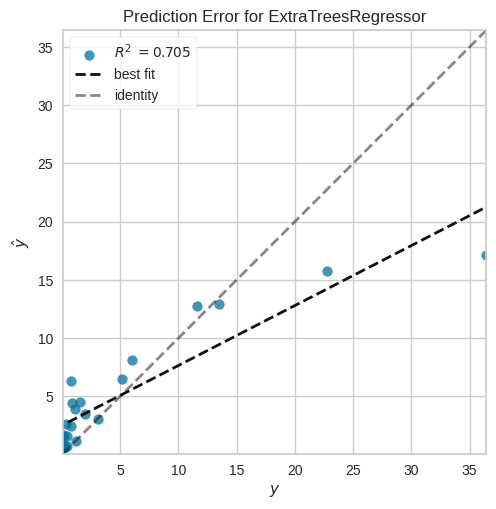

In [72]:
tuned_manual_model_mit = s_mit.tune_model(manual_model_mit, optimize="R2")
s_mit.plot_model(tuned_manual_model_mit, plot="error")